In [37]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
#export
import sys
from pathlib import Path
sys.path.append(Path.cwd().parent.as_posix()+'/BlackBoxAI')
import imports
from callback.callback import listify

In [39]:
#this allows us to plot tensors
torch.Tensor.ndim = property(lambda x: len(x.shape))

In [40]:
#export
def annealer(f):
    def _inner(start, end): return partial(f, start, end)
    return _inner

@annealer
def sched_lin(start, end, pos): return start + pos*(end-start)
@annealer
def sched_cos(start, end, pos): return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2
@annealer
def sched_no(start, end, pos):  return start
@annealer
def sched_exp(start, end, pos): return start * (end/start) ** pos

def cos_1cycle_anneal(start, high, end):
    return [sched_cos(start, high), sched_cos(high, end)]

In [41]:
#export
def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1.
    pcts = tensor([0] + listify(pcts))

    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)
    def _inner(pos):
        #tensor([0.0000, 0.3000, 1.0000])
        idx = (pos >= pcts).nonzero().max()
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos)
    return _inner

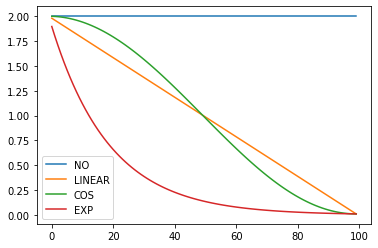

In [42]:
import matplotlib.pyplot as plt
annealings = "NO LINEAR COS EXP".split()

a = torch.arange(0, 100)
p = torch.linspace(0.01,1,100)

fns = [sched_no, sched_lin, sched_cos, sched_exp]
for fn, t in zip(fns, annealings):
    f = fn(2, 1e-2)
    plt.plot(a, [f(o) for o in p], label=t)
plt.legend();

In [43]:
import sys
from pathlib import Path
sys.path.append(Path.cwd().parent.as_posix()+'/BlackBoxAI')
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)])

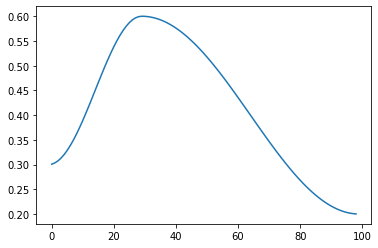

In [44]:
plt.plot(a[:-1], [sched(o) for o in p[:-1]])

In [45]:
!python notebook2script.py helper_annealer.ipynb

Replacing old file
Converted helper_annealer.ipynb to /data/home/jdavey/notebooks/fastai/BlackBoxAI/BlackBoxAI/helper/annealer.py
